In [1]:
import os

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

2025-03-05 16:52:30.629770: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 16:52:30.639593: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741189950.651842   72014 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741189950.655597   72014 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 16:52:30.668053: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
class PreprocessingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(PreprocessingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        min_val = tf.reduce_min(inputs, axis=0)
        max_val = tf.reduce_max(inputs, axis=0)
        normalized_inputs = tf.where(
            max_val - min_val != 0,
            (inputs - min_val) / (max_val - min_val + 1e-8),
            tf.zeros_like(inputs),
        )
        return normalized_inputs

In [3]:
class Autoencoder:
    """Autoencoder that reconstruct METSig distributions and flag anomalies"""

    def __init__(self, input_shape: tuple[int], l2_lambda: float):
        input_layer = tf.keras.Input(shape=input_shape)
        prep_layer = PreprocessingLayer()(input_layer)
        encoded = tf.keras.layers.Dense(18, activation="relu", activity_regularizer=tf.keras.regularizers.l2(l2_lambda))(prep_layer)
        encoded = tf.keras.layers.Dense(8, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(18, activation="sigmoid")(encoded)
        decoded = tf.keras.layers.Dense(input_shape[0], activation="sigmoid")(decoded)
        self.model = tf.keras.models.Model(input_layer, decoded)

        # Since `avg_mse` shares the same layers (prep_layer and decoded) as the `self.model`
        # this `self.stripped_model` doesn't need to be trained
        avg_mse = tf.keras.losses.MSE(prep_layer, decoded)  # Compute the mean squared error for each row in the inputs
        self.stripped_model = tf.keras.models.Model(input_layer, avg_mse)

    def compile(self):
        self.model.compile(optimizer="adam", loss=["mse"], metrics=["mse"])

    def summary(self):
        self.model.summary()

    def predict(self, inputs: np.ndarray):
        return self.model.predict(inputs)

    def fit(self, inputs: np.ndarray, batch_size: int, epochs: int):
        targets = PreprocessingLayer()(inputs)
        history: tf.keras.callbacks.History = self.model.fit(
            inputs, targets, batch_size=batch_size, epochs=epochs
        )
        return history

In [4]:
train_data = np.load("data/data_386642.npy")
train_label = np.load("data/label_386642.npy")

# We want to feed the Autoencoder with GOOD data, so we filter the data by the label == 1
train_data = train_data[train_label == 1]
train_data

array([[1940., 1987.,  670., ...,    0.,    0.,    0.],
       [1869., 1872.,  714., ...,    0.,    0.,    0.],
       [1819., 1924.,  672., ...,    0.,    0.,    0.],
       ...,
       [1171.,  989.,  293., ...,    0.,    0.,    0.],
       [1225.,  960.,  289., ...,    0.,    0.,    0.],
       [1190.,  994.,  257., ...,    0.,    0.,    0.]])

In [5]:
ae = Autoencoder(input_shape=(51,), l2_lambda=1e-4)
ae.compile()
ae.summary()

2025-03-05 16:52:34.653902: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 51)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ preprocessing_layer             │ (None, 51)             │             0 │
│ (PreprocessingLayer)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 18)             │           936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 18)             │           162 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 51)             │           969 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
history = ae.fit(train_data, 128, 200)

Epoch 1/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2280 - mse: 0.2214  
Epoch 2/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2141 - mse: 0.2090 
Epoch 3/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2008 - mse: 0.1967 
Epoch 4/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1885 - mse: 0.1853 
Epoch 5/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1770 - mse: 0.1744 
Epoch 6/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1660 - mse: 0.1640 
Epoch 7/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1554 - mse: 0.1538 
Epoch 8/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1450 - mse: 0.1438 
Epoch 9/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1353 - mse: 0.1343 
Epoch 10/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1262 - mse: 0.1254 
Epoch 11/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1172 - mse: 0.1165 
Epoch 12/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1089 - mse: 0.1083 
Epoch 13/200
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/ste

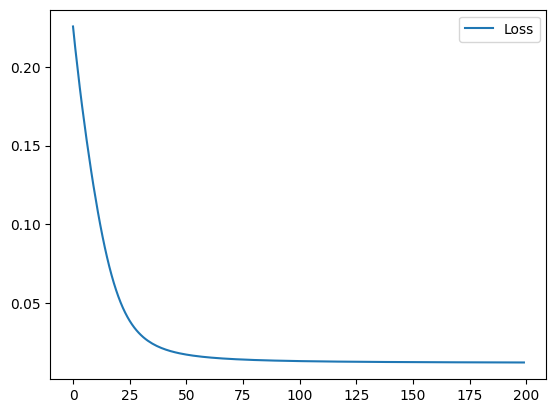

In [7]:
plt.plot(history.history['loss'], label="Loss")
plt.legend()
plt.show()

In [8]:
ae.model.predict(train_data)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([[0.77278346, 0.6978961 , 0.55414665, ..., 0.01567058, 0.0255139 ,
        0.0152659 ],
       [0.77278346, 0.6978961 , 0.55414665, ..., 0.01567058, 0.0255139 ,
        0.0152659 ],
       [0.7728268 , 0.69799846, 0.5541415 , ..., 0.01564432, 0.02548023,
        0.01523753],
       ...,
       [0.7727282 , 0.6978194 , 0.5540776 , ..., 0.0156825 , 0.02553566,
        0.0152702 ],
       [0.77278346, 0.6978961 , 0.55414665, ..., 0.01567058, 0.0255139 ,
        0.0152659 ],
       [0.77278346, 0.6978961 , 0.55414665, ..., 0.01567058, 0.0255139 ,
        0.0152659 ]], dtype=float32)

In [12]:
ae.stripped_model.summary()
ae.stripped_model.predict(train_data)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 51)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ preprocessing_layer │ (None, 51)        │          0 │ input_layer[0][0] │
│ (PreprocessingLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 18)        │        936 │ preprocessing_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 8)         │        152 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 18)        │        162 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 51)        │        969 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convert_to_tensor_1 │ (None, 51)        │          0 │ preprocessing_la… │
│ (ConvertToTensor)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convert_to_tensor   │ (None, 51)        │          0 │ dense_3[0][0]     │
│ (ConvertToTensor)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 51)        │          0 │ convert_to_tenso… │
│                     │                   │            │ convert_to_tenso… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ square (Square)     │ (None, 51)        │          0 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Mean)         │ (None)            │          0 │ square[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,219 (8.67 KB)

 Trainable params: 2,219 (8.67 KB)

 Non-trainable params: 0 (0.00 B)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


array([0.02625392, 0.03192382, 0.04359365, 0.05790412, 0.01040803,
       0.05053362, 0.00876837, 0.01004119, 0.02619381, 0.06219037,
       0.03198015, 0.01206163, 0.04114974, 0.01079934, 0.03893512,
       0.03657918, 0.05422409, 0.05799835, 0.00743811, 0.03463427,
       0.02114946, 0.02237306, 0.02102852, 0.0090321 , 0.00988746,
       0.01974664, 0.01772877, 0.00917191, 0.02670236, 0.01233403,
       0.00743975, 0.00486084, 0.02873793, 0.01229925, 0.02259806,
       0.00646564, 0.05586413, 0.01781443, 0.01879432, 0.00599061,
       0.03141207, 0.02107469, 0.03602971, 0.01009607, 0.01114225,
       0.03590659, 0.03299109, 0.01868774, 0.01924613, 0.04847216,
       0.00949249, 0.02972272, 0.03880122, 0.03772842, 0.03106262,
       0.05424831, 0.01290518, 0.0252893 , 0.03016987, 0.01081999,
       0.01806089, 0.0462181 , 0.00961499, 0.03178373, 0.00879776,
       0.03098842, 0.0061973 , 0.0184636 , 0.0129111 , 0.01540525,
       0.02584731, 0.01199601, 0.03937629, 0.06145121, 0.03968

In [16]:
os.makedirs("./models/tensorflow", exist_ok=True)

model_path = "./models/tensorflow/1/"
tf.saved_model.save(ae.stripped_model, model_path)

# We could save the full model, by referencing ae.model

INFO:tensorflow:Assets written to: ./models/tensorflow/1/assets


INFO:tensorflow:Assets written to: ./models/tensorflow/1/assets
